In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime

In [2]:
data = pd.read_csv('pow1.csv')
today = datetime.datetime.strptime('2023-06-11','%Y-%m-%d')
season_length = 120

In [3]:
data = data[(-data['home'].isin(['None']))].reset_index(drop=True)
data = data[(-data['away'].isin(['None']))].reset_index(drop=True)

In [4]:
# 男子
data = data[(data['tnmt_name']=='多飞春分赛公开组')|(data['tnmt_name']=='香港Hide A-Gender公开组')|(data['tnmt_name']=='岭南公开赛公开组')|(data['tnmt_name']=='上海公开赛公开组')].reset_index(drop=True)

In [5]:
def diff(homes,aways):
    r = (min(homes,aways))/(max(homes,aways)-1)
    x = 125+475*math.sin(min(1,2*(1-r))*0.4*math.pi)/math.sin(0.4*math.pi)
    return x
def wei(homes,aways):
    return min(1,math.sqrt((max(homes,aways)+max(min(homes,aways),math.floor((max(homes,aways)-1)/2)))/19))

In [6]:
min_game = 5
# def get_rate(data,min_game):
ng = len(data)
data.insert(1,'home_r',[1000]*ng)
data.insert(1,'away_r',[1000]*ng)
data.insert(1,'home_e',[1000]*ng)
data.insert(1,'away_e',[1000]*ng)
data.insert(1,'weight',[0]*ng)

itera = 100
sumr = [0]*itera
maxr = [0]*itera
z = pd.DataFrame()


team = list(set(list(data['home']) + list(data['away'])))
n = len(team)
ri = [[0]*itera for i in range(n)]
rate0 = dict(zip(team,[1000]*n))

for i in range(itera):
    data['weight'] = [0]*ng
    
    sumr[i] = sum(rate0.values())
    maxr[i] = max(rate0.values())
        
    game_t = dict()
    for tj in team:
        temp = dict(data[(data['home']==tj) & (data['home_s']>data['away_s'])]['home_e'])
        temp.update(dict(data[(data['away']==tj) & (data['home_s']<data['away_s'])]['away_e']))
        temp = sorted(temp.items(), key=lambda x:x[1], reverse=True)
        z = [0]*min(min_game,len(temp))
        for k in range(min(min_game,len(temp))):
            z[k] = temp[k][0]
        game_t[tj] = z
        if len(z) == 0:
            temp = dict(data[(data['home']==tj)]['home_e'])
            temp.update(dict(data[(data['away']==tj)]['away_e']))
            temp = sorted(temp.items(), key=lambda x:x[1], reverse=False)
            game_t[tj] = [temp[0][0]]
    
    count_g = dict(zip(team,[[] for i in range(n)]))
    for j in range(ng):
        homes = data.loc[j,'home_s']
        aways = data.loc[j,'away_s']
        diffj = diff(homes,aways)
        day_coef = 1-0.5*(today-datetime.datetime.strptime(data.loc[j,'date'],'%Y-%m-%d')).days/season_length
        if homes > aways:
            data.loc[j,'home_e'] = data.loc[j,'away_r'] + diffj
            data.loc[j,'away_e'] = data.loc[j,'home_r'] - diffj
            if (not ((data.loc[j,'home_r'] - data.loc[j,'away_r'] > 600) & (homes > 2*aways+1))):
                data.loc[j,'weight'] = wei(homes,aways) * day_coef
                count_g[data.loc[j,'home']].append(j)
                count_g[data.loc[j,'away']].append(j)
        elif homes < aways:
            data.loc[j,'home_e'] = data.loc[j,'away_r'] - diffj
            data.loc[j,'away_e'] = data.loc[j,'home_r'] + diffj
            if (not ((data.loc[j,'away_r'] - data.loc[j,'home_r'] > 600) & (aways > 2*homes+1))):
                data.loc[j,'weight'] = wei(homes,aways) * day_coef         
                count_g[data.loc[j,'home']].append(j)
                count_g[data.loc[j,'away']].append(j)
        elif homes == aways:
            data.loc[j,'home_e'] = data.loc[j,'away_r']
            data.loc[j,'away_e'] = data.loc[j,'home_r']
            data.loc[j,'weight'] = wei(homes,aways) * day_coef
            count_g[data.loc[j,'home']].append(j)
            count_g[data.loc[j,'away']].append(j)
    
    for tj in team:
        ii = 0
        while len(count_g[tj]) < len(game_t[tj]):
            if game_t[tj][ii] not in count_g[tj]:
                day_coef = 1-0.5*(today-datetime.datetime.strptime(data.loc[game_t[tj][ii],'date'],'%Y-%m-%d')).days/365
                data.loc[game_t[tj][ii],'weight'] = wei(data.loc[game_t[tj][ii],'home_s'],data.loc[game_t[tj][ii],'away_s']) * day_coef
                count_g[tj].append(game_t[tj][ii])
            ii += 1
        
    for tj in team:
        wei_h = np.array(data[(data['home']==tj)]['weight'])
        wei_a = np.array(data[(data['away']==tj)]['weight'])
        r_h = np.array(data[(data['home']==tj)]['home_e'])
        r_a = np.array(data[(data['away']==tj)]['away_e'])
        if (sum(wei_h)+sum(wei_a)) == 0:
            rate0[tj] = min(list(data[(data['home']==tj)]['home_e'])+list(data[(data['away']==tj)]['away_e']))
        else:
            rate0[tj] = (sum(wei_h*r_h)+sum(wei_a*r_a))/(sum(wei_h)+sum(wei_a))
        
    for j in range(ng):
        data.loc[j,'home_r'] = rate0[data.loc[j,'home']]
        data.loc[j,'away_r'] = rate0[data.loc[j,'away']]
    
    for k in range(n):
        ri[k][i] = rate0[team[k]]
#     return rate0
# rate0 = get_rate(data,5)

C:\Users\yanha\AppData\Local\Temp\ipykernel_13408\2213569057.py:2: RuntimeWarning: invalid value encountered in scalar divide
  r = (min(homes,aways))/(max(homes,aways)-1)


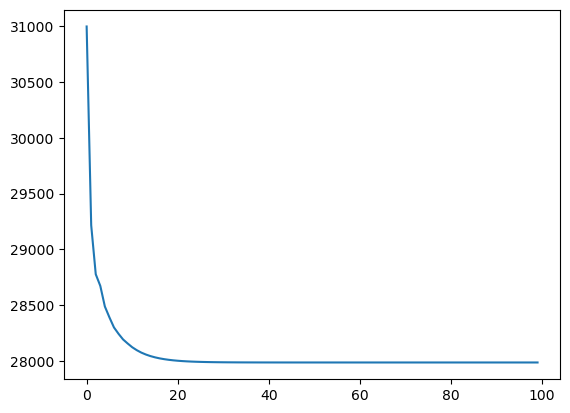

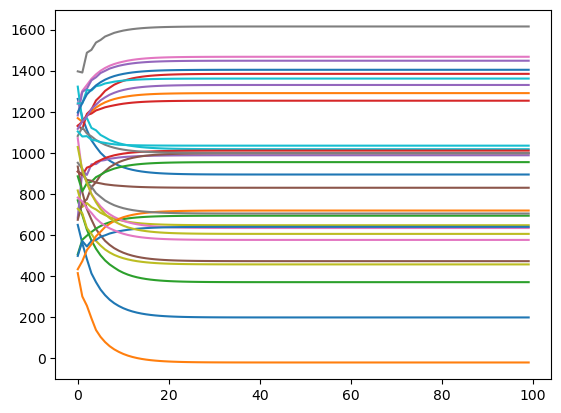

In [7]:
plt.plot(np.arange(0,itera,1),sumr)
plt.show()
for i in range(n):
    plt.plot(np.arange(0,itera,1),ri[i])
plt.show()

In [8]:
n_win = dict(zip(team,[0]*n))
n_tie = dict(zip(team,[0]*n))
n_loss = dict(zip(team,[0]*n))
for i in range(len(data)):
    if data.loc[i,'home_s'] > data.loc[i,'away_s']:
        n_win[data.loc[i,'home']] += 1
        n_loss[data.loc[i,'away']] += 1
    if data.loc[i,'home_s'] < data.loc[i,'away_s']:
        n_loss[data.loc[i,'home']] += 1
        n_win[data.loc[i,'away']] += 1
    if data.loc[i,'home_s'] == data.loc[i,'away_s']:
        n_tie[data.loc[i,'home']] += 1
        n_tie[data.loc[i,'away']] += 1

In [15]:
rate = pd.DataFrame(list(rate0.items()),columns=['team','rating']).sort_values(by=['rating'],ascending=False)
ranking = rate.reset_index(drop=True)
ranking.insert(1,'lose',[0]*n)
ranking.insert(1,'tie',[0]*n)
ranking.insert(1,'win',[0]*n)
ranking['sum_weight'] = [0]*n
for i in range(len(ranking)):
    ranking.loc[i,'win'] = n_win[ranking.loc[i,'team']]
    ranking.loc[i,'tie'] = n_tie[ranking.loc[i,'team']]
    ranking.loc[i,'lose'] = n_loss[ranking.loc[i,'team']]
    ranking.loc[i,'sum_weight'] = sum(data[(data['home']==ranking.loc[i,'team']) | (data['away']==ranking.loc[i,'team'])]['weight'])

ranking.insert(1,'rank',['-']*n)
j = 1
for i in range(len(ranking)):
    if ranking.loc[i,'win']+ranking.loc[i,'tie']+ranking.loc[i,'lose'] >= 10:
        ranking.loc[i,'rank'] = int(j)
        j += 1
        
ranking.loc[0:50,]
#ranking[ranking['win']+ranking['tie']+ranking['lose'] >= 10].reset_index(drop=True).loc[0:50,]

,team,rank,win,tie,lose,rating,sum_weight
0,Chuchai,1,10,1,2,1614.808879,10.432210
1,SuperStorm,2,13,1,5,1467.432128,14.533758
2,Flash,3,14,0,5,1448.225122,15.285149
3,HK Open,4,12,0,7,1404.101357,16.481956
4,HK White,-,3,0,3,1384.311247,4.418912
5,Wind Wizards,-,5,0,2,1361.347949,6.421647
6,老炮儿,5,13,0,8,1330.235700,17.914864
7,Feipanda K,-,5,0,3,1290.571959,5.251551
8,迈克虎男队,6,10,0,5,1253.673561,12.574784
9,杭儿疯,7,9,0,4,1034.959851,10.946968


In [10]:
game_1 = data[['home','home_s','away_s','away','home_r','away_r','home_e','away_e','weight','tnmt_name','date']]
game_2 = data[['home','home_s','away_s','away','home_r','away_r','home_e','away_e','weight','tnmt_name','date']]
game_2.columns = ['away','away_s','home_s','home','away_r','home_r','away_e','home_e','weight','tnmt_name','date']
game = pd.concat([game_1,game_2],axis=0)

In [11]:
temp = ranking[['team','rank']]
temp.columns = ['away','rank']
game = pd.merge(game,temp,how='inner',on='away')
temp = ranking[['team','sum_weight']]
temp.columns = ['home','sum_weight']
game = pd.merge(game,temp,how='inner',on='home')
game['weight%'] = game['weight']/game['sum_weight']
game['effect'] = round((game['home_e']-game['home_r'])*game['weight%'],1)
game['weight%'] = game['weight%'].apply(lambda x: format(x, '.2%')) 

In [12]:
game['result'] = ['']*len(game)
for i in range(len(game)):
    if game.loc[i,'home_s'] < game.loc[i,'away_s']:
        game.loc[i,'result'] = str(game.loc[i,'home_s'])+':'+str(game.loc[i,'away_s'])+' 负'
    elif game.loc[i,'home_s'] > game.loc[i,'away_s']:
        game.loc[i,'result'] = str(game.loc[i,'home_s'])+':'+str(game.loc[i,'away_s'])+' 胜'
    else:
        game.loc[i,'result'] = str(game.loc[i,'home_s'])+':'+str(game.loc[i,'away_s'])+' 平'

In [13]:
game = game[['home','result','rank','away','effect','weight%','tnmt_name','date']]
game

,home,result,rank,away,effect,weight%,tnmt_name,date
0,Dark Raven,18:5 胜,-,Sambro,0.3,7.97%,多飞春分赛公开组,2023-03-18
1,Dark Raven,9:7 胜,10,Swingman,22.6,7.32%,多飞春分赛公开组,2023-03-18
2,Dark Raven,10:12 负,-,Superjet男队,6.4,7.97%,多飞春分赛公开组,2023-03-18
3,Dark Raven,11:9 胜,9,同济河豚,30.1,7.97%,多飞春分赛公开组,2023-03-18
4,Dark Raven,7:9 负,-,Gravity男队,-16.2,7.32%,多飞春分赛公开组,2023-03-18
...,...,...,...,...,...,...,...,...
311,Feipanda K,13:5 胜,-,肉夹馍男队,-0.0,0.00%,岭南公开赛公开组,2023-05-13
312,Feipanda K,13:4 胜,-,肉夹馍男队,-0.0,0.00%,岭南公开赛公开组,2023-05-13
313,Feipanda K,11:12 负,6,迈克虎男队,-27.1,16.74%,岭南公开赛公开组,2023-05-13
314,Feipanda K,13:7 胜,6,迈克虎男队,87.2,16.74%,岭南公开赛公开组,2023-05-13


In [14]:
tnmt_n = list(set(game['tnmt_name']))
team_cnt = [0]*len(tnmt_n)
rating_4 = [0]*len(tnmt_n)
rating_8 = [0]*len(tnmt_n)
rating_avg = [0]*len(tnmt_n)
l_w = [0]*len(tnmt_n)
for i in range(len(tnmt_n)):
    team_cnt[i] = len(set(data[data['tnmt_name']==tnmt_n[i]]['home']) | set(data[data['tnmt_name']==tnmt_n[i]]['away']))
    temp = list(set(data[data['tnmt_name']==tnmt_n[i]]['home_r']) | set(data[data['tnmt_name']==tnmt_n[i]]['away_r']))
    temp.sort(reverse=True)
    if len(temp) >= 4:
        rating_4[i] = temp[3]
    if len(temp) >= 8:
        rating_8[i] = temp[7]
    rating_avg[i] = np.average(temp)

    temp_da = data[data['tnmt_name']==tnmt_n[i]].reset_index(drop=True)
    temp_l = [0]*len(temp_da)
    for j in range(len(temp_da)):
        temp_l[j] = min(temp_da.loc[j,'home_s'],temp_da.loc[j,'away_s'])/max(temp_da.loc[j,'home_s'],temp_da.loc[j,'away_s'])
    l_w[i] = np.average(temp_l)
temp_df = {'tnmt_name':tnmt_n, 'team_cnt':team_cnt, 'rating_4':rating_4, 'rating_8':rating_8, 'rating_avg':rating_avg, 'l_w':l_w}
tnmt= pd.DataFrame(data=temp_df).sort_values(by=['rating_4'],ascending=False).reset_index(drop=True)
tnmt

,tnmt_name,team_cnt,rating_4,rating_8,rating_avg,l_w
0,香港Hide A-Gender公开组,8,1404.101357,719.266766,1295.781340,0.578518
1,上海公开赛公开组,20,1404.101357,1034.959851,939.241722,0.599207
2,岭南公开赛公开组,12,1330.235700,1010.833919,1113.259873,0.567209
3,多飞春分赛公开组,8,634.206710,-19.986951,585.354802,0.598483


In [ ]:
game.to_csv('game_m.csv')
ranking.to_csv('ranking_m.csv')
tnmt.to_csv('tnmt_m.csv')